# ESA ESDL's Ocean Data Cube for Principal Component Analysis on Time Variability
**A DeepESDL Science Case notebook** 


This notebook is part of the [Ocean Carbon Cycle Science Case](https://earthsystemdatalab.net/science_cases/ocean/).

Authors: Julia Klima, Jannes Kruse, Jonas Neumann

-----------------

**This notebook runs with the python environment `users-deepesdl-xcube-1.11.0`, please checkout the documentation for [help on changing the environment](https://earthsystemdatalab.net/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kernel).**

In [63]:
import dask
import numpy as np
import xarray as xr
import dask.array as da
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from dask.diagnostics import ProgressBar


import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Download the Data

In [64]:
cube_path = "https://s3.eu-central-1.amazonaws.com/deep-esdl-public/ocean-1M-9km-1x1080x1080-1.4.0.levels/0.zarr"

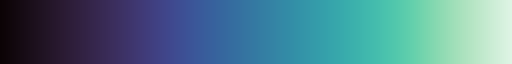

In [65]:
mako_cmap=sns.color_palette("mako", as_cmap=True)
display(mako_cmap)

Color map used in the maps of the annual mean variations, zoomed into the region of interest

In [66]:
# Open the dataset in parallel using dask by specifying chunks (using "auto" for automatic chunking)
cube_ds = xr.open_zarr(cube_path, consolidated=True, chunks="auto")
cube_ds

<xarray.Dataset> Size: 136GB
Dimensions:       (time: 280, lat: 2160, lon: 4320)
Coordinates:
  * lat           (lat) float32 9kB -89.96 -89.88 -89.79 ... 89.79 89.88 89.96
  * lon           (lon) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * time          (time) datetime64[ns] 2kB 1997-09-01 1997-10-01 ... 2020-12-01
Data variables: (12/13)
    C_microphyto  (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    C_nanophyto   (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    C_phyto       (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    C_picophyto   (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    DOC           (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    EP_Dunne      (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    ...            ...
    EP_Li         (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    PIC           (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    POC           (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    chl_a         (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mld           (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    pp            (time, lat, lon) float32 10GB dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Attributes: (12/21)
    Conventions:                CF-1.10
    acknowledgment:             All data providers are acknowledged inside ea...
    contributor_name:           ['University of Leipzig', 'Brockmann Consult ...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    project:                    DeepESDL
    publisher_name:             DeepESDL Team
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2020-12-01T00:00:00.000000000
    time_coverage_start:        1997-09-01T00:00:00.000000000
    title:                      BICEP Pools and Fluxes of the Ocean Biologica...

In [67]:
#validate the type of the data
print("This is the type of the data", type(cube_ds))
#validate the keys
print("The available keys \n", list(cube_ds.data_vars.keys()))

This is the type of the data <class 'xarray.core.dataset.Dataset'>
The available keys 
 ['C_microphyto', 'C_nanophyto', 'C_phyto', 'C_picophyto', 'DOC', 'EP_Dunne', 'EP_Henson', 'EP_Li', 'PIC', 'POC', 'chl_a', 'mld', 'pp']


**About the study region**
- Region of the Nino3.4 (5N-5S, 170W-120W), east-central equatorial Pacific from the ESDC

In [68]:
cube_region = cube_ds.sel(lat=slice(-5,5), lon=slice(-170, -120))

In [69]:
#A View to the variables
cube_region.data_vars.keys()

KeysView(Data variables:
    C_microphyto  (time, lat, lon) float32 81MB dask.array<chunksize=(1, 60, 600), meta=np.ndarray>
    C_nanophyto   (time, lat, lon) float32 81MB dask.array<chunksize=(1, 60, 600), meta=np.ndarray>
    C_phyto       (time, lat, lon) float32 81MB dask.array<chunksize=(1, 60, 600), meta=np.ndarray>
    C_picophyto   (time, lat, lon) float32 81MB dask.array<chunksize=(1, 60, 600), meta=np.ndarray>
    DOC           (time, lat, lon) float32 81MB dask.array<chunksize=(1, 60, 600), meta=np.ndarray>
    EP_Dunne      (time, lat, lon) float32 81MB dask.array<chunksize=(1, 60, 600), meta=np.ndarray>
    EP_Henson     (time, lat, lon) float32 81MB dask.array<chunksize=(1, 60, 600), meta=np.ndarray>
    EP_Li         (time, lat, lon) float32 81MB dask.array<chunksize=(1, 60, 600), meta=np.ndarray>
    PIC           (time, lat, lon) float32 81MB dask.array<chunksize=(1, 60, 600), meta=np.ndarray>
    POC           (time, lat, lon) float32 81MB dask.array<chunksize=(1, 60

In [70]:
print(cube_region.sizes)
print(cube_region.lat.values[:5])  # Print first 5 latitudes
print(cube_region.lat.values[-5:])  # Print last 5 latitudes

Frozen({'time': 280, 'lat': 120, 'lon': 600})
[-4.958333 -4.875    -4.791667 -4.708333 -4.625   ]
[4.625    4.708333 4.791667 4.875    4.958333]


Since part of the latitudes are decreasing and part are increasing, we need to sort them into a consistent order before plotting

In [71]:
cube_region = cube_region.sortby("lat")  # Ensure latitudes are properly ordered
print(cube_region.lat.values[:5])  
print(cube_region.lat.values[-5:])  

[-4.958333 -4.875    -4.791667 -4.708333 -4.625   ]
[4.625    4.708333 4.791667 4.875    4.958333]


## First Exploratory Visualization

In [72]:
# We have a dict_keys (or KeysView), so we need to convert to a list...
first_var = list(cube_region.data_vars.keys())[0]
print(first_var)
#Select the dataset
data_array = cube_region[first_var]
print(data_array)
print(data_array.sizes)

C_microphyto
<xarray.DataArray 'C_microphyto' (time: 280, lat: 120, lon: 600)> Size: 81MB
dask.array<getitem, shape=(280, 120, 600), dtype=float32, chunksize=(1, 60, 600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 480B -4.958 -4.875 -4.792 ... 4.792 4.875 4.958
  * lon      (lon) float32 2kB -170.0 -169.9 -169.8 ... -120.2 -120.1 -120.0
  * time     (time) datetime64[ns] 2kB 1997-09-01 1997-10-01 ... 2020-12-01
Attributes: (12/13)
    acknowledgement:        BICEP/NCEO
    color_bar_name:         YlGnBu_r
    color_value_max:        200
    color_value_min:        0
    description:            Microphytoplankton Carbon in Sea Water
    long_name:              Microphytoplankton Carbon
    ...                     ...
    original_name:          C_microphyto
    original_scale_factor:  1.0
    processing_steps:       ['Gridding nc datasets']
    source:                 https://rsg.pml.ac.uk/shared_files/gku/ESA_animat...
    standard_name:          mass_concentrati

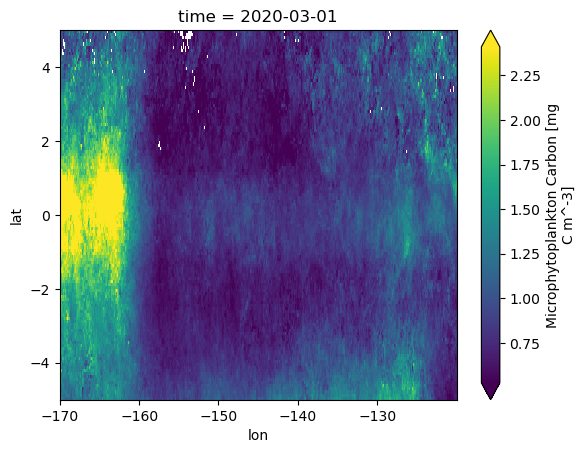

In [73]:
#Plot the data with a target variable called "Microphytoplankton"
data_array.isel(time=270).plot(
    x="lon", y="lat", robust=True
)
plt.show()


### How to interpret these results? - Spatial Patterns

- High concentrations (~yellow) are seen around ~160°W near the equator (likely due to nutrient upwelling)
- Patchy areas (~white spots) might indicate missing data or high variability
- Gradual change from west to east suggest a biogeochemical gradient (possible influenced by ocean currents or nutriet availability)

# Exploratory Data analysis

Understanding the complex dynamics of oceanographic variables is essential for assessing ecological patterns, climate change impacts, and biogeochemical cycles. This exploratory data analysis (EDA) aims to examine a dataset of oceanographic variables across a specified region in the Pacific Ocean, focusing on the period from 2018 to 2020, by leveraging statistical analysis, visualization techniques, and machine learning approaches.

## Exploratory Plots, Data Distribution

In [74]:
summary_stats = []
for varname in list(cube_region.data_vars.keys()):
    data = cube_region[varname]  # Keep as xarray.DataArray (Dask-aware)

    print(f"Checking {varname}:")
    sample_data = data.isel(time=slice(270, 280))

    # Compute min, max, and NaN percentage only on the sample
    min_val = sample_data.min().compute().values
    max_val = sample_data.max().compute().values
    nan_percent = 100 * sample_data.isnull().mean().compute().values  # Efficient NaN count
    # Append results to list
    summary_stats.append({"Variable": varname, "Min": min_val, "Max": max_val, "% NaN": nan_percent})

# Convert list to DataFrame
df_summary = pd.DataFrame(summary_stats)

df_summary

Checking C_microphyto:
Checking C_nanophyto:
Checking C_phyto:
Checking C_picophyto:
Checking DOC:
Checking EP_Dunne:
Checking EP_Henson:
Checking EP_Li:
Checking PIC:
Checking POC:
Checking chl_a:
Checking mld:
Checking pp:


Variable           Min          Max       % NaN
0   C_microphyto    0.16798833     6.746703    0.191528
1    C_nanophyto     0.5681898    15.662707    0.191528
2        C_phyto      3.848866     46.61602    0.191528
3    C_picophyto     3.1126878    25.430044    0.191528
4            DOC           nan          nan  100.000000
5       EP_Dunne           nan          nan  100.000000
6      EP_Henson           nan          nan  100.000000
7          EP_Li           nan          nan  100.000000
8            PIC  6.154282e-05  0.001142164   10.175278
9            POC     23.363209     185.2734    0.188194
10         chl_a    0.05201313    0.7983995    0.188194
11           mld     16.075281   102.704216    0.000000
12            pp      194.3061    1340.3114    0.000000

We are going to use PlateCarree projection for proper zoom in the region

In [75]:
proj = ccrs.PlateCarree()  

**Computational Considerations**

- uses .resample(time="Y").mean(), Faster than groupby("time.year").mean()
- processes one year at a time (avoids memory overload)
- uses .coarsen(lat=2, lon=2) to speed up large datasets
- skips years with no valid data (avoids unnecessary computations).
- displays progress (print(f"Processing {year}...")).

In [78]:
def plotAllYears(varname):
    """Plots the annual mean of a variable, zoomed into the region of interest."""
    
    # Extract unique years
    years = np.unique(cube_region.time.dt.year.values)

    # Set up a grid (max 4 columns per row)
    col_wrap = 4  
    ncols = min(col_wrap, len(years))  
    nrows = int(np.ceil(len(years) / col_wrap))

    # Create figure
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(4.5 * ncols, 4.5 * nrows),  
        subplot_kw={"projection": proj},
        constrained_layout=True  
    )

    # Ensure axes is iterable
    axes = np.atleast_1d(axes).flatten()

    # Set zoomed-in region (El Niño3.4 area)
    region_extent = [-170, -120, -5, 5]  # lon_min, lon_max, lat_min, lat_max

    # Process each year separately to avoid memory overload
    for i, (year, ax) in enumerate(zip(years, axes)):
        ax.set_extent(region_extent, crs=ccrs.PlateCarree())  # Zoom into the region
        ax.coastlines()

        print(f"Processing {varname} for {year}...")

        # Compute annual mean for the specific year
        data_slice = cube_region[varname].sel(time=str(year)).resample(time="Y").mean().compute()

        # Remove the extra time dimension (ensure 2D: lat, lon)
        data_slice = data_slice.squeeze()

        # Skip if all values are NaN
        if np.isnan(data_slice).all():
            print(f"Skipping {year}: No valid data")
            ax.set_title(f"{int(year)} (No Data)", fontsize=10)
            continue

        # Compute color limits dynamically
        vmin = np.nanpercentile(data_slice, 5)
        vmax = np.nanpercentile(data_slice, 95)

        # Plot using pcolormesh with adjusted scaling
        mesh = ax.pcolormesh(
            data_slice.lon, data_slice.lat, data_slice,
            transform=ccrs.PlateCarree(),
            cmap=mako_cmap.reversed(),
            vmin=vmin, vmax=vmax,
            shading="auto"
        )

        # Add gridlines
        grd = ax.gridlines(
            draw_labels=True,
            xlocs=range(-180, 181, 10),  # Finer grid for zoomed view
            ylocs=range(-10, 11, 2),
            linewidth=0.5,
            color="#09081f"
        )
        grd.top_labels = False
        grd.right_labels = False

        # Set title for each subplot
        ax.set_title(f"{int(year)}", fontsize=10)

    # Remove unused axes
    for j in range(len(years), len(axes)):
        fig.delaxes(axes[j])

    # Add colorbar
    cbar = fig.colorbar(mesh, ax=axes, orientation="horizontal", fraction=0.02, aspect=40)
    cbar.ax.tick_params(labelsize=7.5)
    cbar.outline.set_color("white")

    # Add main title
    plt.suptitle(f"Annual Mean of {varname} (Zoomed into El Niño Region)", fontsize=14)


Processing C_microphyto for 1997...
Skipping 1997: No valid data
Processing C_microphyto for 1998...
Processing C_microphyto for 1999...
Processing C_microphyto for 2000...
Processing C_microphyto for 2001...
Processing C_microphyto for 2002...
Processing C_microphyto for 2003...
Processing C_microphyto for 2004...
Processing C_microphyto for 2005...
Processing C_microphyto for 2006...
Processing C_microphyto for 2007...
Processing C_microphyto for 2008...
Processing C_microphyto for 2009...
Processing C_microphyto for 2010...
Processing C_microphyto for 2011...
Processing C_microphyto for 2012...
Processing C_microphyto for 2013...
Processing C_microphyto for 2014...
Processing C_microphyto for 2015...
Processing C_microphyto for 2016...
Processing C_microphyto for 2017...
Processing C_microphyto for 2018...
Processing C_microphyto for 2019...
Processing C_microphyto for 2020...


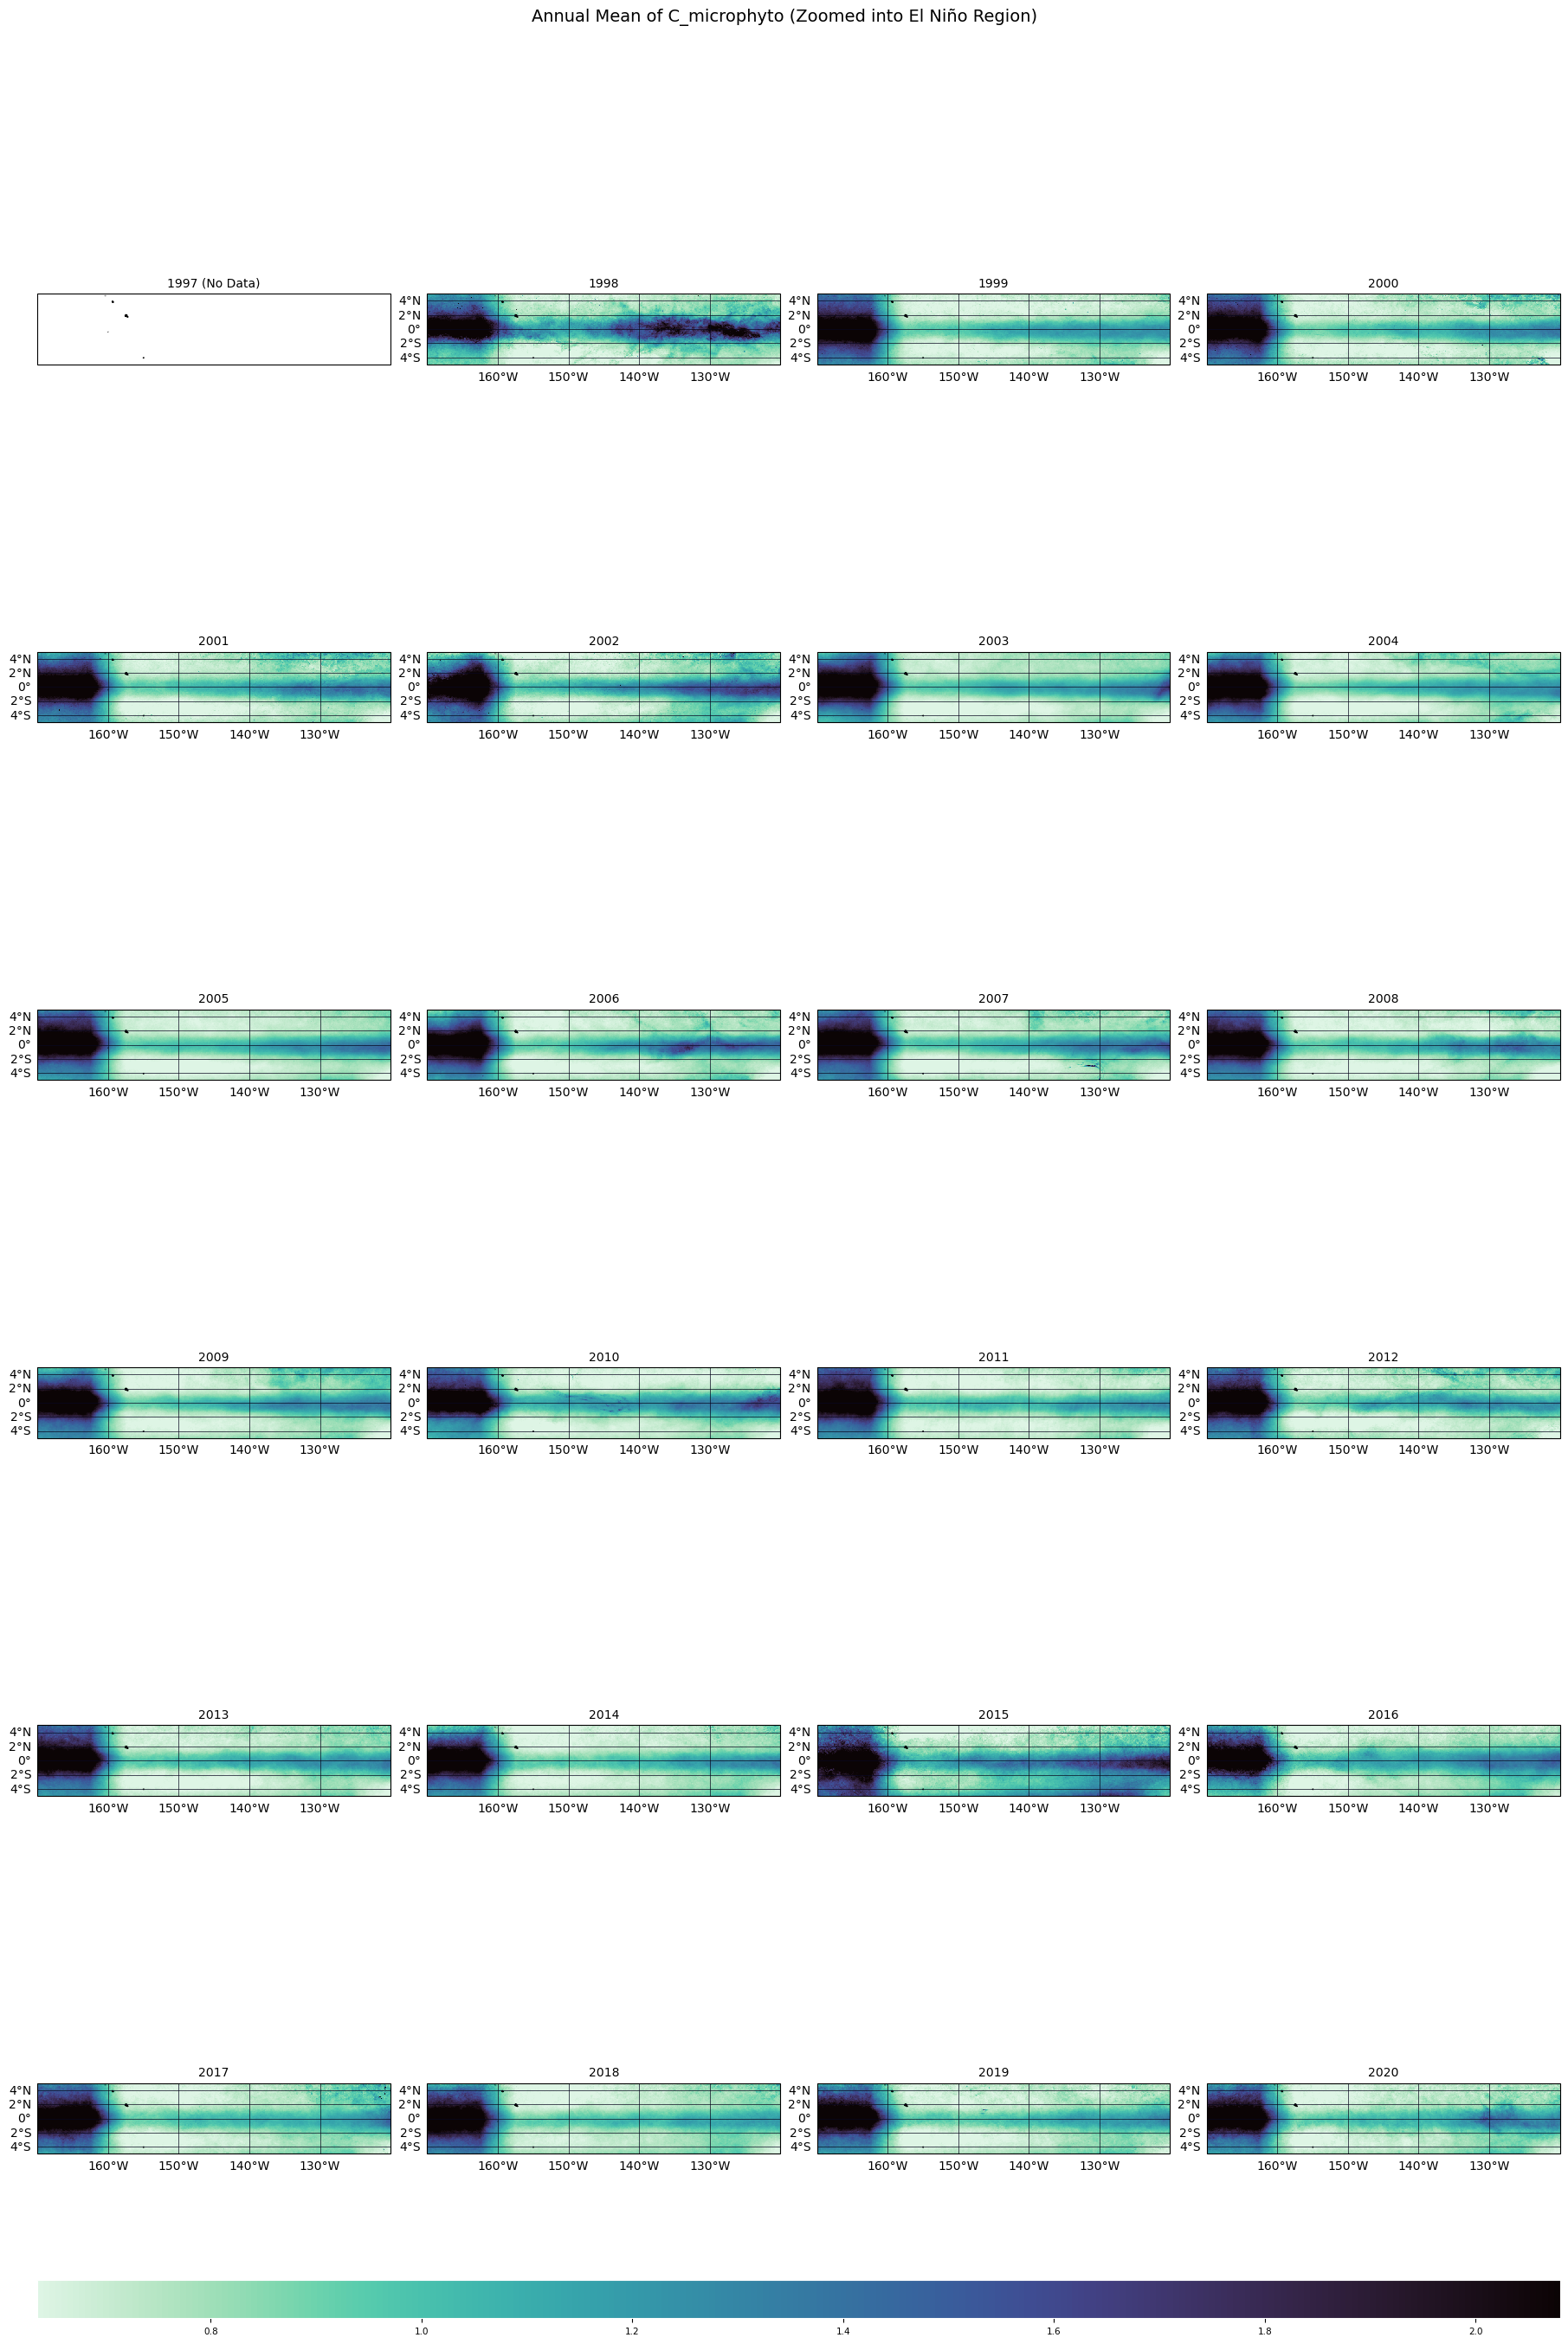

In [79]:
plotAllYears("C_microphyto") #You can change it for any variable

**Conclusions from the  annual mean concentration of microphytoplankton ($C_microphyto$)carbon in the region ($lat: -5° to 5°, lon: -170° to -120°$), from 1997 to 2020**.

- Each subplot represents a single year, highlighting how phytoplankton biomass has varied over time
- There is a highly distributed microphytoplankton biomass concentration between 1998 and 2015-2016. Maybe this is linked with *El Niño* events?
- Light areas are associated with low concentrations of phytoplankton biomass

**Some questions...**
- Does the intensity of phytoplankton growth increase or decrease over time?
- Are the high-biomass years becoming more frequent?

## Time Series Analysis

### Annual Trend analysis 

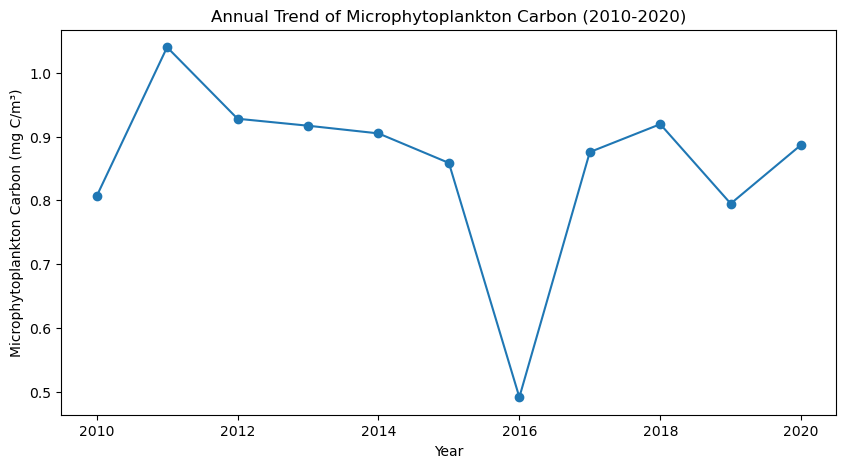

In [80]:
# Select one time step in the last 10 years, from 2010 to 2020
years = np.arange(2010, 2021)
phyto_means = []

for year in years:
    data_slice = cube_region["C_microphyto"].sel(time=str(year), method="nearest").mean(dim=["lat", "lon"]).compute()
    phyto_means.append(data_slice.values)

# Plot annual trend
plt.figure(figsize=(10, 5))
plt.plot(years, phyto_means, marker="o", linestyle="-")
plt.xlabel("Year")
plt.ylabel("Microphytoplankton Carbon (mg C/m³)")
plt.title("Annual Trend of Microphytoplankton Carbon (2010-2020)")
plt.show()

**Insights from the annual trend of Micophytoplankton Carbon (2010-2020)**

- The phytoplankton carbon levels exhibit fluctuations over the years rather than a steady increase or decrease.

- The highest recorded value is around 2011, suggesting a period of higher productivity

- A dramatic drop in phytoplankton carbon occurs in 2016, indicating a potential disturbance

- After the minimum in 2016, there is a strong recovery in 2017, reaching near previous levels, suggesting that the ecosystem was able to rebound.

- The graph also shows an interannual variability, which may be linked to climatic events, ocean circulation changes, or biological interactions affecting Microphytoplankton Carbon growth.

### Seasonal Cycle

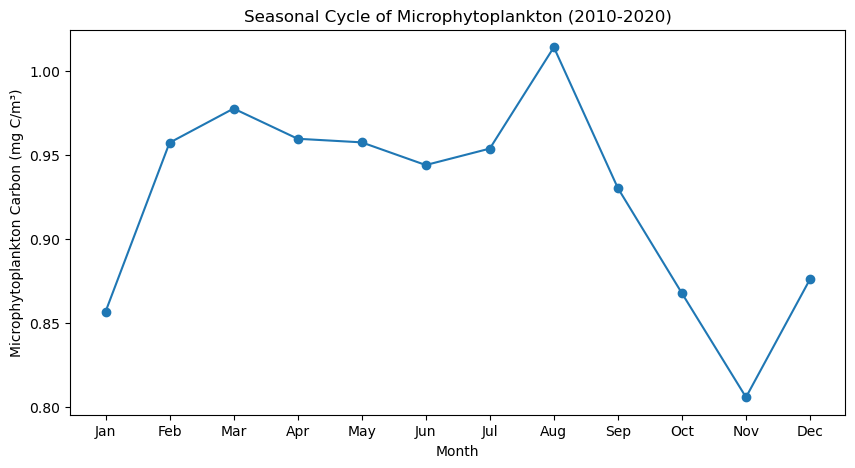

In [81]:
# Define years & months
years = np.arange(2010, 2021)
months = np.arange(1, 13)  # January to December

# Initialize storage for monthly values
monthly_means = np.zeros((len(years), len(months)))

# Loop over years & months to compute monthly averages
for i, year in enumerate(years):
    for j, month in enumerate(months):
        try:
            # Select nearest available time step for the given month & year
            data_slice = cube_region["C_microphyto"].sel(time=f"{year}-{month:02d}", method="nearest").mean(dim=["lat", "lon"]).compute()
            monthly_means[i, j] = data_slice.values
        except:
            monthly_means[i, j] = np.nan  # Handle missing data

# Compute average seasonal cycle over 2010-2020
seasonal_cycle = np.nanmean(monthly_means, axis=0)

# Plot seasonal cycle
plt.figure(figsize=(10, 5))
plt.plot(months, seasonal_cycle, marker="o", linestyle="-")
plt.xlabel("Month")
plt.ylabel("Microphytoplankton Carbon (mg C/m³)")
plt.title("Seasonal Cycle of Microphytoplankton (2010-2020)")
plt.xticks(months, labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


**Insights from the seasonal cycle of Micophytoplankton Carbon (2010-2020)**

- November is the month with a lower production
- There is a decreasing trend in the concentration from August to November
- We can observe a steady period from February to July
- The maximum production month is August

### Mean Spatial Distribution from 2010-2020 of Microphytoplankton

In [82]:
# Select data from 2010 to 2020
phyto_2010_2020 = cube_region["C_microphyto"].sel(time=slice("2010", "2020")).compute()

# Compute basic statistics
stats_summary = {
    "Mean": float(phyto_2010_2020.mean().values),
    "Median": float(phyto_2010_2020.median().values),
    "Min": float(phyto_2010_2020.min().values),
    "Max": float(phyto_2010_2020.max().values),
    "Standard Deviation": float(phyto_2010_2020.std().values),
    "25th Percentile": float(phyto_2010_2020.quantile(0.25).values),
    "75th Percentile": float(phyto_2010_2020.quantile(0.75).values),
}

# Print summary
for k, v in stats_summary.items():
    print(f"{k}: {v:.4f}")


Mean: 0.9267
Median: 0.7664
Min: 0.0569
Max: 232.1885
Standard Deviation: 0.5401
25th Percentile: 0.6132
75th Percentile: 1.0639


**Insights from results:**

- Mean= 0.9267, is the typical microphytoplankton concentration in the region
- The mean (0.9267) is greater than the median (0.7664) → Suggests right-skewed (positively skewed) distribution
- Standard deviation = 0.5, shows a moderate spread in values. Some areas have very high phytoplankton, while others are low.

### About the Data Distribution

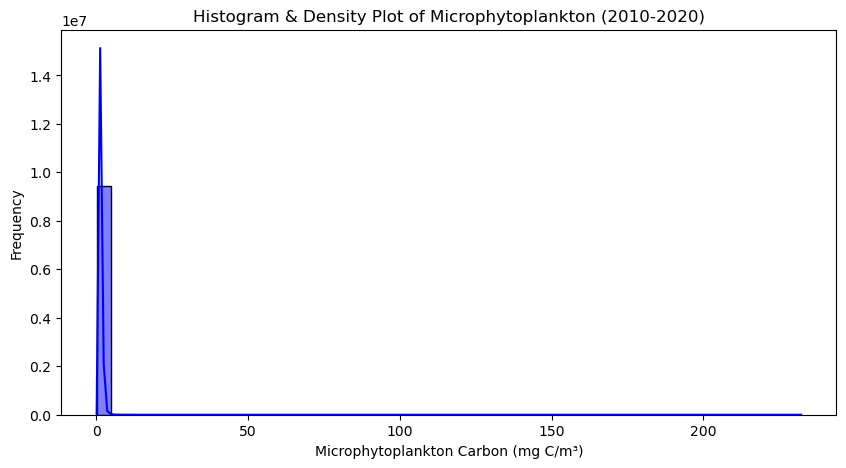

In [83]:
# Flatten the data for 1D analysis
phyto_flat = phyto_2010_2020.values.flatten()

# Remove NaNs
phyto_flat = phyto_flat[~np.isnan(phyto_flat)]

# Plot histogram & KDE
plt.figure(figsize=(10, 5))
sns.histplot(phyto_flat, bins=50, kde=True, color="blue")
plt.xlabel("Microphytoplankton Carbon (mg C/m³)")
plt.ylabel("Frequency")
plt.title("Histogram & Density Plot of Microphytoplankton (2010-2020)")
plt.show()

We have an extremely right-skewed distribution with most of the values near zero. 

The high frequency of low values compresses the histogram on the left hiding details. Let's move to a log scale...

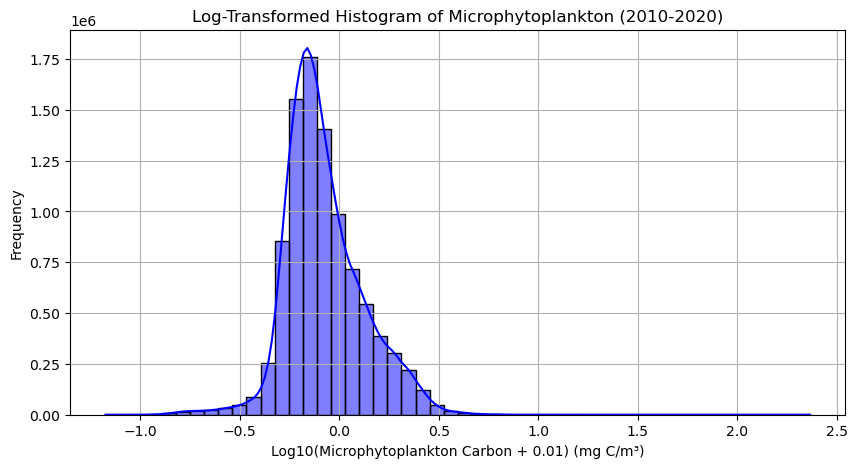

In [84]:
# Log Scales
# Remove NaNs and flatten data
phyto_flat = phyto_2010_2020.values.flatten()
phyto_flat = phyto_flat[~np.isnan(phyto_flat)]

# Apply Log Transformation (Avoid Zero by Adding a Small Value)
phyto_log = np.log10(phyto_flat + 0.01)  # Adding 0.01 to avoid log(0) error

# Plot Histogram & KDE
plt.figure(figsize=(10, 5))
sns.histplot(phyto_log, bins=50, kde=True, color="blue")
plt.xlabel("Log10(Microphytoplankton Carbon + 0.01) (mg C/m³)")
plt.ylabel("Frequency")
plt.title("Log-Transformed Histogram of Microphytoplankton (2010-2020)")
plt.grid()
plt.show()

**This diagram looks much better than the original, let's break it down:**

- Before applying the log transformation, most values were very close to 0, while a few extreme values $e.g., 232 mg C/m³$ stretched the x-axis.

- This skewed distribution suggests that high Microphytoplankton concentrations occur in rare events, possibly linked to upwelling, seasonal blooms, or climate effects (El Niño/La Niña).

- The log-transformed histogram now appears closer to a normal (bell-shaped) distribution.

- This indicates that the original data followed a multiplicative pattern, where small values were common, and large values occurred exponentially less frequently.

Text(0.5, 1.0, 'Mean Mircrophytoplankton Carbon (2010-2020)')

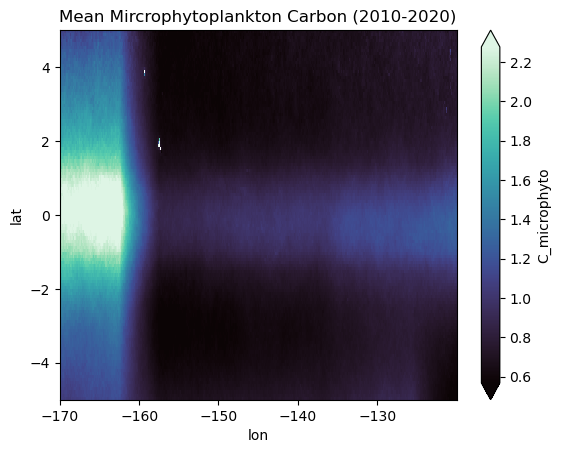

In [85]:
#Compute mean over the selected time range
mean_2010_2010 = phyto_2010_2020.mean(dim="time").compute()
#plot the mean spatial distribution
mean_2010_2010.plot(
    x="lon", y="lat", cmap="mako", robust=True
)
plt.title("Mean Mircrophytoplankton Carbon (2010-2020)")

The mean of the spatial distributions is high in the left and lower on the right

### Skewnees & Kurtosis Test

In [86]:
print(f"Skewness: {skew(phyto_flat):.4f}")  # Measures symmetry
print(f"Kurtosis: {kurtosis(phyto_flat):.4f}")  # Measures tail weight

Skewness: 31.5569
Kurtosis: 10041.0186


- A normal distribution has kurtosis ≈ 3
- This kurtosis is over 10,000! This means there are many high values
- The amount of outliers, indicates that Microphytoplankton concentrations have rare but extreme spikes, which could be linked to seasonal upwelling 
- While the positive Skewness remarks the fact of the Extremely right-skewed distribution (long tail on the right).

### Variance Overe Time

/home/conda/users/d8e564ca1f6100996eb8829d28de8c1f2f179e893f75a04414cad12358733d7d-20250227-084056-483690-679-oceancube/lib/python3.12/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


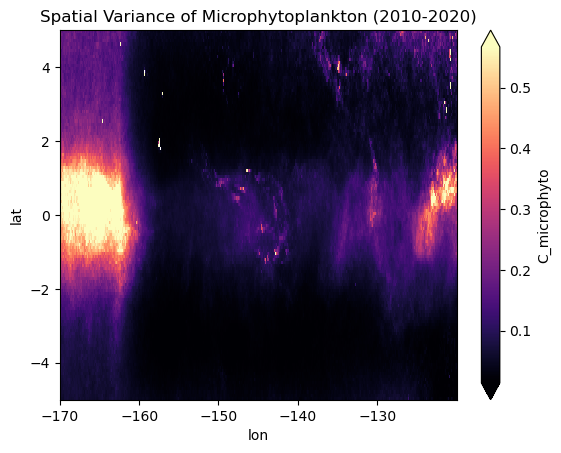

In [87]:
phyto_var = phyto_2010_2020.var(dim="time").compute()

# Plot variance
phyto_var.plot(x="lon", y="lat", cmap="magma", robust=True)
plt.title("Spatial Variance of Microphytoplankton (2010-2020)")
plt.show()

### Mapping Ouliers to Check Where and When Occurs

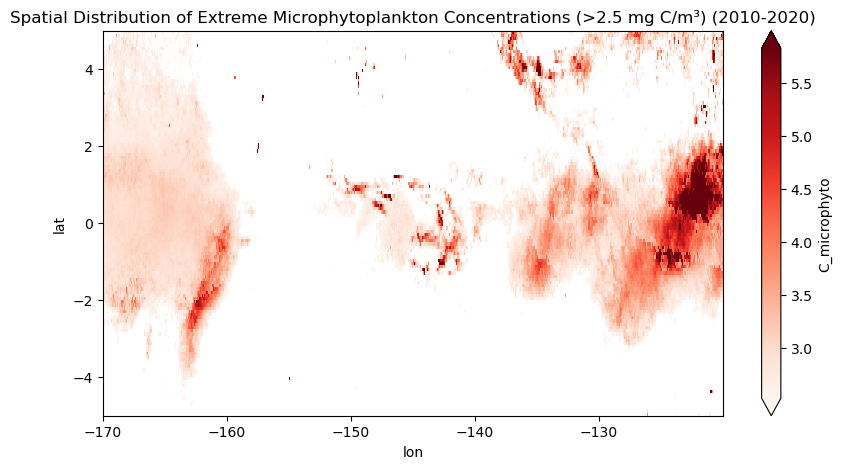

In [88]:
# Mask values below 2.5 mg C/m³ (keep only extreme values
phyto_extreme = phyto_2010_2020.where(phyto_2010_2020 > 2.5)

# Compute mean of extreme values over time to get persistent hotspots
phyto_extreme_mean = phyto_extreme.mean(dim="time")

# Plot the spatial distribution of extreme values
plt.figure(figsize=(10, 5))
phyto_extreme_mean.plot(
    x="lon", y="lat", cmap="Reds", robust=True
)
plt.title("Spatial Distribution of Extreme Microphytoplankton Concentrations (>2.5 mg C/m³) (2010-2020)")
plt.show()

This heatmap shows areas where Microphytoplankton Carbon concentrations exceeded 2.5 mg C/m³ during 2010-2020. These regions represent phytoplankton blooms, which may be linked to upwelling, seasonal cycles, or climate events.

# Pre-processing

**Steps performed in this script**

- Clean the cube by nans

- Select a smaller subset of the data

- Log transform the cube to fix the skewed distribution 

- Spatial-temporally interpolate the cube 

5. Z-transform/Standardize each var for each pixel over time

In [89]:
# Load Dataset (2019-2020)
cube = cube_region.sel(time=slice("2019", "2020"))

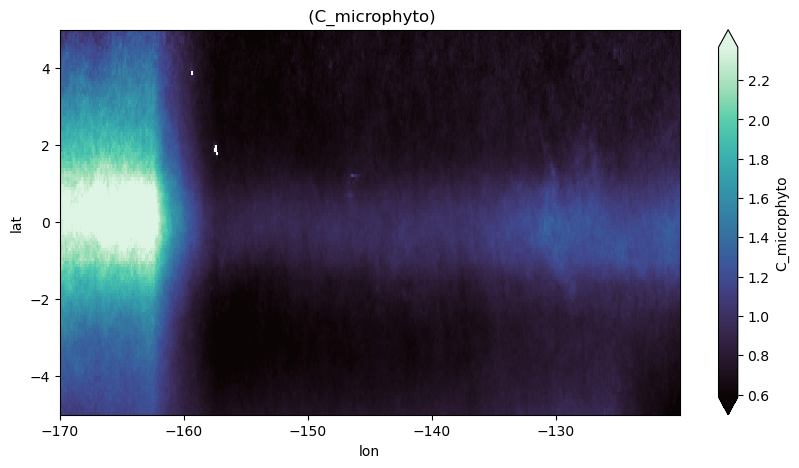

In [90]:
# Function to visualize data
def plot_variable(varname, title=""):
    plt.figure(figsize=(10, 5))
    cube[varname].mean(dim="time").plot(x="lon", y="lat", cmap="mako", robust=True)
    plt.title(f"{title} ({varname})")
    plt.show()
plot_variable("C_microphyto", title="")

In [91]:
# Compute the percentage of missing values per variable
missing_values = cube.isnull().mean(dim="time") * 100  

# Print summary statistics
for var in cube.data_vars:
    missing_pct = missing_values[var].values.mean()
    print(f"{var}: {missing_pct:.2f}% missing values on average")

C_microphyto: 0.49% missing values on average
C_nanophyto: 0.49% missing values on average
C_phyto: 0.49% missing values on average
C_picophyto: 0.49% missing values on average
DOC: 100.00% missing values on average
EP_Dunne: 50.97% missing values on average
EP_Henson: 50.00% missing values on average
EP_Li: 50.00% missing values on average
PIC: 4.49% missing values on average
POC: 0.33% missing values on average
chl_a: 0.49% missing values on average
mld: 0.00% missing values on average
pp: 0.00% missing values on average


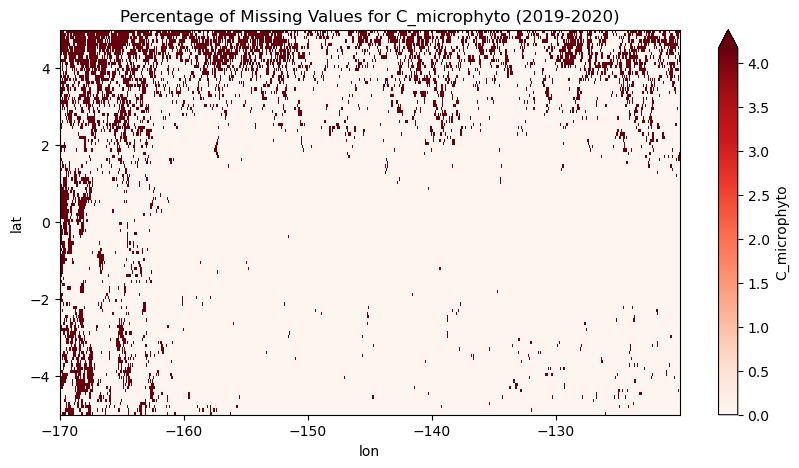

In [92]:
#Visualize missing data spatially, for our target data: C_microphyto
plt.figure(figsize=(10,5))
missing_values["C_microphyto"].plot(x="lon", y="lat", cmap="Reds", robust=True)
plt.title("Percentage of Missing Values for C_microphyto (2019-2020)")
plt.show()

In [93]:
#Removing the missing values
# Set the missing value threshold (50%)
nan_threshold = 50  

# Identify variables exceeding the threshold
vars_to_drop = [var for var in cube.data_vars if missing_values[var].mean().values > nan_threshold]

# Drop the selected variables
cube_filtered = cube.drop_vars(vars_to_drop)

print(f"Dropped variables (>{nan_threshold}% NaNs): {vars_to_drop}")
print("Remaining variables:", list(cube_filtered.data_vars.keys()))

Dropped variables (>50% NaNs): ['DOC', 'EP_Dunne', 'EP_Henson', 'EP_Li']
Remaining variables: ['C_microphyto', 'C_nanophyto', 'C_phyto', 'C_picophyto', 'PIC', 'POC', 'chl_a', 'mld', 'pp']


Now we have dropped unreliable variables, storing the data in cube_filtered, we can interpolate the remaining ones to fill out the missing values.

## Spatial and Temporal Interpolation with Parallelism (Dask)

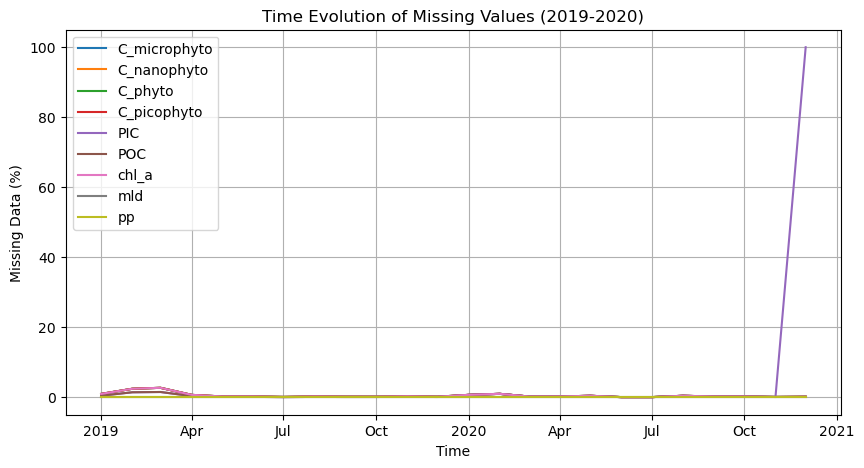

In [94]:
# Check where the missing values are
missing_time = cube_filtered.isnull().mean(dim=["lat", "lon"]) * 100  
plt.figure(figsize=(10, 5))
for var in cube_filtered.data_vars:
    missing_time[var].plot(label=var)

plt.title("Time Evolution of Missing Values (2019-2020)")
plt.ylabel("Missing Data (%)")
plt.xlabel("Time")
plt.legend()
plt.grid()
plt.show()

- Most variables have <5% missing values throughout the period, Good quality data
- A sharp increase in missing values for PIC at the end of 2020, 100% missing in late 2020
- A few minor fluctuations (e.g., chl_a, POC in early 2019), but mostly stable
- Variables like mld, pp have almost no missing values, Reliable.

## Parallel Spatial Interpolation

In [95]:
@dask.delayed
def temporal_interpolate(var):
    """Apply parallel temporal interpolation (linear)."""
    return var.interpolate_na(dim="time", method="linear")

# Run temporal interpolation in parallel
tasks = [temporal_interpolate(cube_filtered[var]) for var in cube_filtered.data_vars]

with dask.diagnostics.ProgressBar():
    cube_temp_filled = dask.compute(*tasks)

# Convert back to xarray dataset
cube_temp_filled = xr.Dataset({var: cube_temp_filled[i] for i, var in enumerate(cube_filtered.data_vars)})

print("Parallel temporal interpolation completed!")


[########################################] | 100% Completed | 10.94 ss
Parallel temporal interpolation completed!


In [96]:
# Validation results
# Compute remaining missing values after time interpolation
remaining_nans = cube_temp_filled.isnull().sum()

if remaining_nans == 0:
    print("All missing values filled using temporal interpolation!")
else:
    print(f"{remaining_nans} missing values remain. Proceeding to spatial interpolation.")

All missing values filled using temporal interpolation!


### Verify the Interpolation

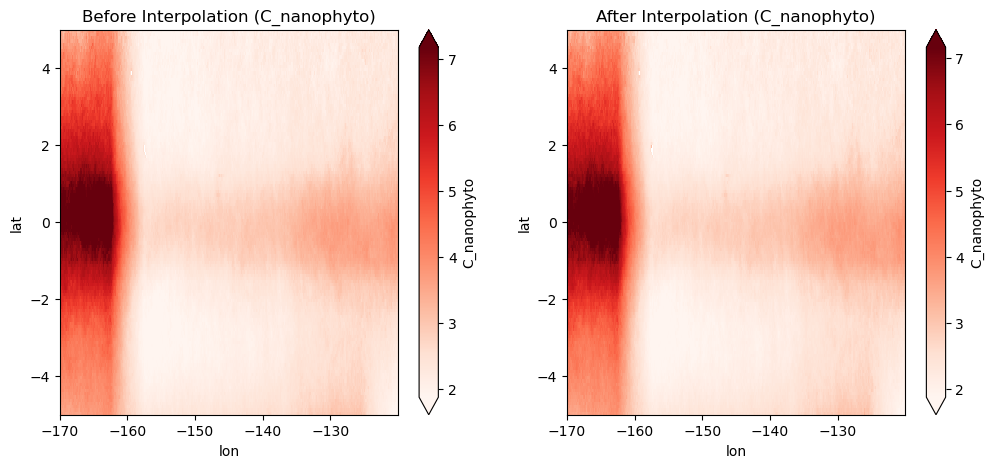

In [97]:
varname = "C_nanophyto"  # Example variable

plt.figure(figsize=(12, 5))

# Before interpolation
plt.subplot(1, 2, 1)
cube_filtered[varname].mean(dim="time").plot(x="lon", y="lat", cmap="Reds", robust=True)
plt.title(f"Before Interpolation ({varname})")

# After interpolation
plt.subplot(1, 2, 2)
cube_temp_filled[varname].mean(dim="time").plot(x="lon", y="lat", cmap="Reds", robust=True)
plt.title(f"After Interpolation ({varname})")

plt.show()

## Apply Z-Transformation (Standardization)

In [98]:

# Initialize scaler
scaler = StandardScaler()

# Stack the dataset so each variable is shaped as (time, lat, lon)
cube_flat = cube_temp_filled.stack(points=("lat", "lon"))

# Apply Z-transform for each variable independently
for varname in cube_flat.data_vars:
    reshaped = cube_flat[varname].values  # Shape (time, points)
    reshaped_scaled = scaler.fit_transform(reshaped.T).T  # Standardize along time
    cube_flat[varname].values = reshaped_scaled  # Replace with normalized values

# Unstack to restore original dimensions
cube_normalized = cube_flat.unstack()
print("Z-transformation completed: Data is now normalized!")


Z-transformation completed: Data is now normalized!


/home/conda/users/d8e564ca1f6100996eb8829d28de8c1f2f179e893f75a04414cad12358733d7d-20250227-084056-483690-679-oceancube/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/conda/users/d8e564ca1f6100996eb8829d28de8c1f2f179e893f75a04414cad12358733d7d-20250227-084056-483690-679-oceancube/lib/python3.12/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/conda/users/d8e564ca1f6100996eb8829d28de8c1f2f179e893f75a04414cad12358733d7d-20250227-084056-483690-679-oceancube/lib/python3.12/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [99]:
# Compute the percentage of missing values per variable
missing_values = cube_normalized.isnull().mean(dim="time") * 100  

# Print summary statistics
for var in cube_normalized.data_vars:
    missing_pct = missing_values[var].values.mean()
    print(f"{var}: {missing_pct:.2f}% missing values on average")

C_microphyto: 0.06% missing values on average
C_nanophyto: 0.06% missing values on average
C_phyto: 0.06% missing values on average
C_picophyto: 0.06% missing values on average
PIC: 4.20% missing values on average
POC: 0.03% missing values on average
chl_a: 0.06% missing values on average
mld: 0.00% missing values on average
pp: 0.00% missing values on average


In [100]:
# Count total NaNs in PCA output
nan_count = np.isnan(cube_normalized).sum()

if nan_count == 0:
    print("No NaN values found in the dataset!")
else:
    print(f"Warning: {nan_count} NaN values found in results.")


No NaN values found in the dataset!


In [101]:
for var in cube_normalized.data_vars:
    mean_value = cube_normalized[var].mean().values  # Compute mean
    cube_normalized[var] = cube_normalized[var].fillna(mean_value)


In [102]:
# Compute the percentage of missing values per variable, a next time
missing_values = cube_normalized.isnull().mean(dim="time") * 100  

# Print summary statistics
for var in cube_normalized.data_vars:
    missing_pct = missing_values[var].values.mean()
    print(f"{var}: {missing_pct:.2f}% missing values on average")

C_microphyto: 0.00% missing values on average
C_nanophyto: 0.00% missing values on average
C_phyto: 0.00% missing values on average
C_picophyto: 0.00% missing values on average
PIC: 0.00% missing values on average
POC: 0.00% missing values on average
chl_a: 0.00% missing values on average
mld: 0.00% missing values on average
pp: 0.00% missing values on average


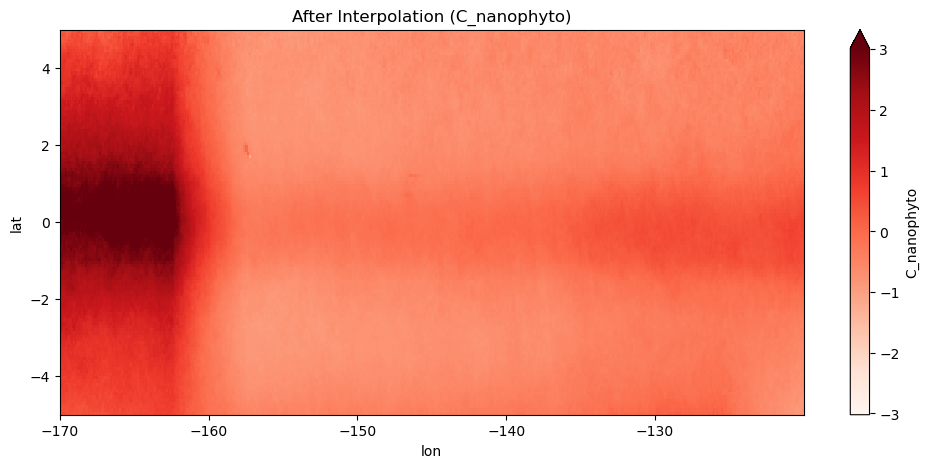

In [103]:
varname = "C_nanophyto"  # Example variable

plt.figure(figsize=(12, 5))
cube_normalized[varname].mean(dim="time").plot(x="lon", y="lat", cmap="Reds", robust=True)
plt.title(f"After Interpolation ({varname})")

plt.show()

# PCA - Analysis Principal Components

In [104]:
df = cube_normalized.to_dataframe().dropna(axis=0) 
print(f"Data reshaped for PCA: {df.shape}")
df_to_pca = df.reset_index().iloc[:, 3:]

Data reshaped for PCA: (1728000, 9)


In [105]:
df_to_pca.head()

C_microphyto  C_nanophyto   C_phyto  C_picophyto       PIC       POC  \
0      0.750745     0.871909  1.366134     1.600487 -0.533502 -1.919654   
1     -0.582531    -0.551773 -0.374905    -0.272896  0.977315  0.855367   
2      0.357911     0.469580  0.961251     1.193546 -1.990066 -1.960416   
3     -0.461399    -0.330163  0.634930     1.111382 -1.917981 -2.786921   
4      0.305837     0.429998  1.005271     1.266385 -1.429722 -1.939942   

      chl_a       mld        pp  
0 -0.989729  1.448499  1.339629  
1 -1.027582  1.180518  0.016442  
2 -1.087765  1.596308 -1.588839  
3 -2.396936  0.759695 -2.524424  
4 -1.444392  1.617762 -2.107470

In [106]:
# Apply PCA
pca = PCA(n_components=0.95, svd_solver="auto")  # Keep 95% variance
pca.fit(df)

# Extract PCA results
components = pca.components_  # Principal component loadings
componentsT = components.T  # Transpose for readability
sv = pca.singular_values_  # Singular values
num_pcs = len(sv)  # Number of principal components
pcs_evar = pca.explained_variance_ratio_  # Variance explained by each PC
pc1_evar = pcs_evar[0]  # Variance explained by PC1

# Identify the most important variable in PC1
cubekeys = df.columns
max_value = np.max(abs(components[0]))  
max_variable = cubekeys[np.argsort(abs(components[0]))[-1]]  # Most contributing variable

# Print PCA results
print("Singular values:")
display(pd.DataFrame(sv, columns=["Singular Values"]))

print("Principal Components (95% Variance):")
display(pd.DataFrame(componentsT, columns=[f'PC{i+1}' for i in range(num_pcs)], index=cubekeys))

print("Explained Variance per Component:")
display(pd.DataFrame(pcs_evar.round(3), columns=["Explained Variance"]))

print(f"Maximum Loading Value in PC1: {max_value}")
print(f"Variable Contributing Most to PC1: {max_variable}")


Singular values:


Singular Values
0      2804.405762
1      2159.395752
2      1144.848267
3       999.627869

Principal Components (95% Variance):


PC1       PC2       PC3       PC4
C_microphyto  0.453663 -0.132100 -0.069108  0.006189
C_nanophyto   0.446736 -0.171880 -0.094799  0.019267
C_phyto       0.411040 -0.277423 -0.157945  0.059037
C_picophyto   0.381553 -0.331023 -0.188746  0.079328
PIC           0.074724  0.422143 -0.269024  0.808976
POC           0.267045  0.458130  0.119735  0.064028
chl_a         0.312974  0.392668  0.261343 -0.177242
mld          -0.033116 -0.388362  0.759399  0.500845
pp            0.322698  0.270863  0.440419 -0.221382

Explained Variance per Component:


Explained Variance
0               0.508
1               0.301
2               0.085
3               0.065

Maximum Loading Value in PC1: 0.45366331934928894
Variable Contributing Most to PC1: C_microphyto


In [107]:
# Apply K-Means clustering on PCA loadings
kmeans = KMeans(n_clusters=num_pcs + 1, n_init=len(cubekeys), random_state=42).fit(componentsT)
clusters = kmeans.predict(componentsT)
cluster_centers = kmeans.cluster_centers_
clusters_df = pd.DataFrame(clusters, index=cubekeys, columns=['Cluster'])

# Compute distances to cluster centers
d_list = defaultdict(list)

for i, c in enumerate(clusters):
    dist = euclidean_distances([componentsT[i, :]], [cluster_centers[c, :]])[0][0]
    d_list[c].append((i, dist))

# Select most important variables for each cluster
indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in d_list.values()]
featurekeys = [cubekeys[i] for i in indices_]

# Print PFA results
print("Clustered variables from Components:")
display(clusters_df)

print("Most important features for the pixel are:")
display(pd.DataFrame(featurekeys, columns=["Variable"]))


Clustered variables from Components:


Cluster
C_microphyto        0
C_nanophyto         0
C_phyto             0
C_picophyto         0
PIC                 2
POC                 4
chl_a               1
mld                 3
pp                  1

Most important features for the pixel are:


Variable
0  C_phyto
1      PIC
2      POC
3    chl_a
4      mld

### Visualization Results

In [108]:
# Convert PCA results into DataFrame with lat/lon
pca_df = pd.concat([df.reset_index()[["lat", "lon"]], pd.DataFrame(components.T, columns=[f"PC{i+1}" for i in range(num_pcs)])], axis=1)

print("PCA results with spatial coordinates:")
pca_df.head()

PCA results with spatial coordinates:


lat         lon       PC1       PC2       PC3       PC4
0 -4.958333 -169.958344  0.453663 -0.132100 -0.069108  0.006189
1 -4.958333 -169.958344  0.446736 -0.171880 -0.094799  0.019267
2 -4.958333 -169.958344  0.411040 -0.277423 -0.157945  0.059037
3 -4.958333 -169.958344  0.381553 -0.331023 -0.188746  0.079328
4 -4.958333 -169.958344  0.074724  0.422143 -0.269024  0.808976

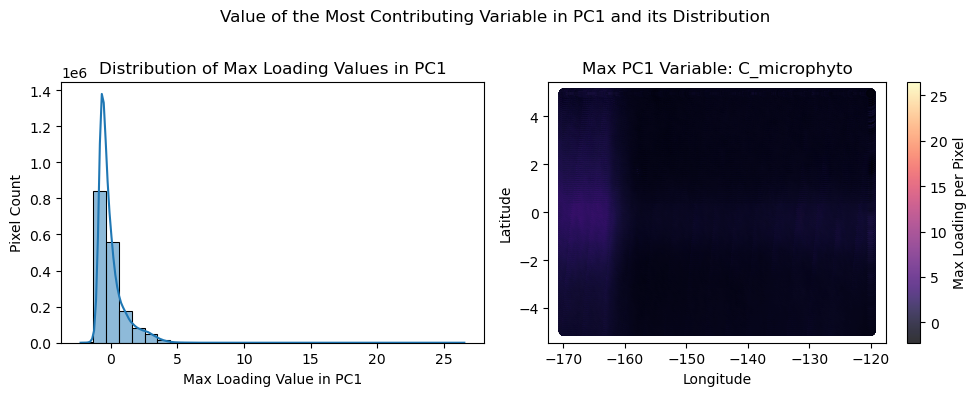

In [109]:
# Extract PC1 loadings
df_pca = df.reset_index()
pc1_loadings = np.abs(components[0])  # Absolute values for contribution strength
max_loading_idx = np.argmax(pc1_loadings)  # Index of max loading variable
max_variable = cubekeys[max_loading_idx]  # Most contributing variable in PC1

# Extract max PC1 loading per pixel
pc1_values = df_pca[max_variable].values  # Get values of the most contributing variable

# Convert to DataFrame for plotting
pca_results = df_pca[["lat", "lon"]].copy()
pca_results["Max_PC1_Loading"] = pc1_values

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Histogram of PC1 Loadings
sns.histplot(pca_results["Max_PC1_Loading"], bins=30, kde=True, ax=ax[0])
ax[0].set_title("Distribution of Max Loading Values in PC1")
ax[0].set_xlabel("Max Loading Value in PC1")
ax[0].set_ylabel("Pixel Count")

# Spatial Map of PC1 Contributions
sc = ax[1].scatter(
    pca_results["lon"], pca_results["lat"], c=pca_results["Max_PC1_Loading"],
    cmap="magma", alpha=0.8
)
ax[1].set_title(f"Max PC1 Variable: {max_variable}")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
plt.colorbar(sc, ax=ax[1], label="Max Loading per Pixel")

# Show plots
plt.suptitle("Value of the Most Contributing Variable in PC1 and its Distribution")
plt.tight_layout()
plt.show()


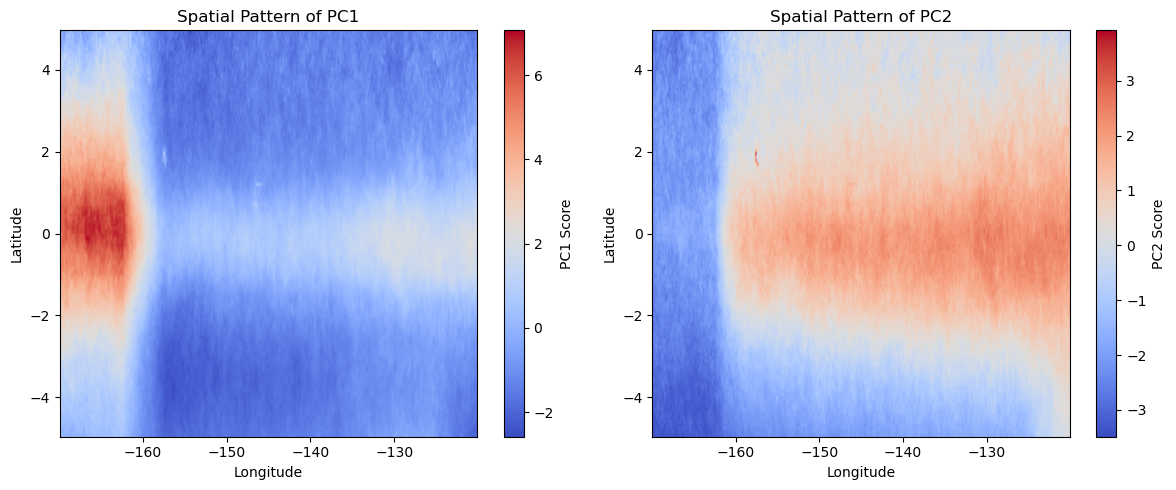

In [110]:
# Transform original data using PCA
X_pca = pca.transform(df)  # Project data onto principal components

# Create a DataFrame with PCA scores
df_pca_scores = df_pca[["lat", "lon", "time"]].copy()  # Keep spatial-temporal info
df_pca_scores["PC1"] = X_pca[:, 0]  # Add first principal component
df_pca_scores["PC2"] = X_pca[:, 1]  # Add second principal component

# Aggregate by lat-lon (mean PC scores per pixel over time)
df_pca_spatial = df_pca_scores.groupby(["lat", "lon"])[["PC1", "PC2"]].mean().reset_index()

# Step 4: Pivot to reshape into (lat, lon) grid
pc1_grid = df_pca_spatial.pivot(index="lat", columns="lon", values="PC1").values
pc2_grid = df_pca_spatial.pivot(index="lat", columns="lon", values="PC2").values

# Step 5: Plot spatial patterns of PCA components
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# PC1 Spatial Plot
pc1_plot = ax[0].imshow(pc1_grid, cmap="coolwarm", aspect="auto", origin="lower",
                         extent=[df_pca_spatial["lon"].min(), df_pca_spatial["lon"].max(),
                                 df_pca_spatial["lat"].min(), df_pca_spatial["lat"].max()])
ax[0].set_title("Spatial Pattern of PC1")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
plt.colorbar(pc1_plot, ax=ax[0], label="PC1 Score")

# PC2 Spatial Plot
pc2_plot = ax[1].imshow(pc2_grid, cmap="coolwarm", aspect="auto", origin="lower",
                         extent=[df_pca_spatial["lon"].min(), df_pca_spatial["lon"].max(),
                                 df_pca_spatial["lat"].min(), df_pca_spatial["lat"].max()])
ax[1].set_title("Spatial Pattern of PC2")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
plt.colorbar(pc2_plot, ax=ax[1], label="PC2 Score")

plt.tight_layout()
plt.show()

In [111]:
df_pca_scores["PC3"] = X_pca[:, 2]  #add a third component
df_pca_scores["PC4"] = X_pca[:, 3]  #add a fourth
df_pca_spatial = df_pca_scores.groupby(["lat", "lon"])[["PC1", "PC2", "PC3", "PC4"]].mean().reset_index()
df_pca_spatial.head()

lat         lon       PC1       PC2       PC3       PC4
0 -4.958333 -169.958344 -0.126739 -3.161545  0.183795  0.522673
1 -4.958333 -169.875000 -0.121202 -3.194854  0.208601  0.493204
2 -4.958333 -169.791656  0.199110 -3.177928  0.274710  0.432470
3 -4.958333 -169.708344  0.152246 -3.308702  0.295777  0.323877
4 -4.958333 -169.625000  0.102756 -3.235543  0.273294  0.445419

In [112]:
# Merge PCA scores with clusters assignments
# Merge PCA spatial data with clusters
pca_clusters = df_pca_spatial.copy()
pca_clusters["Cluster"] = kmeans.predict(df_pca_spatial[["PC1", "PC2", "PC3", "PC4"]])
pca_clusters

/home/conda/users/d8e564ca1f6100996eb8829d28de8c1f2f179e893f75a04414cad12358733d7d-20250227-084056-483690-679-oceancube/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


lat         lon       PC1       PC2       PC3       PC4  Cluster
0     -4.958333 -169.958344 -0.126739 -3.161545  0.183795  0.522673        3
1     -4.958333 -169.875000 -0.121202 -3.194854  0.208601  0.493204        3
2     -4.958333 -169.791656  0.199110 -3.177928  0.274710  0.432470        3
3     -4.958333 -169.708344  0.152246 -3.308702  0.295777  0.323877        3
4     -4.958333 -169.625000  0.102756 -3.235543  0.273294  0.445419        3
...         ...         ...       ...       ...       ...       ...      ...
71995  4.958333 -120.375000 -1.502605 -0.344784 -0.832969 -0.514151        0
71996  4.958333 -120.291672 -1.411373 -0.206836 -0.888015 -0.354770        0
71997  4.958333 -120.208328 -1.560445 -0.391581 -0.890117 -0.482957        0
71998  4.958333 -120.125000 -1.554593 -0.616047 -0.815826 -0.789872        0
71999  4.958333 -120.041672 -1.408063 -0.222593 -0.882699 -0.374348        0

[72000 rows x 7 columns]

In [113]:
# Pivot table to reshape into (lat, lon) grid
clusters_map = pca_clusters.pivot(index="lat", columns="lon", values="Cluster")
clusters_map.head()

lon        -169.958344  -169.875000  -169.791656  -169.708344  -169.625000  \
lat                                                                          
-4.958333            3            3            3            3            3   
-4.875000            3            3            3            3            3   
-4.791667            3            3            3            3            3   
-4.708333            3            3            3            3            3   
-4.625000            3            3            3            3            3   

lon        -169.541656  -169.458344  -169.375000  -169.291656  -169.208344  \
lat                                                                          
-4.958333            3            3            3            3            3   
-4.875000            3            3            3            3            3   
-4.791667            3            3            3            3            3   
-4.708333            3            3            3            3            3   
-4.625000            3            3            3            3            3   

lon        ...  -120.791672  -120.708328  -120.625000  -120.541672  \
lat        ...                                                       
-4.958333  ...            3            2            2            2   
-4.875000  ...            2            4            2            2   
-4.791667  ...            2            2            2            2   
-4.708333  ...            4            4            2            2   
-4.625000  ...            2            2            2            2   

lon        -120.458328  -120.375000  -120.291672  -120.208328  -120.125000  \
lat                                                                          
-4.958333            2            2            2            4            2   
-4.875000            2            2            2            2            2   
-4.791667            2            2            2            2            2   
-4.708333            4            2            2            2            2   
-4.625000            2            2            2            2            2   

lon        -120.041672  
lat                     
-4.958333            2  
-4.875000            4  
-4.791667            2  
-4.708333            2  
-4.625000            2  

[5 rows x 600 columns]

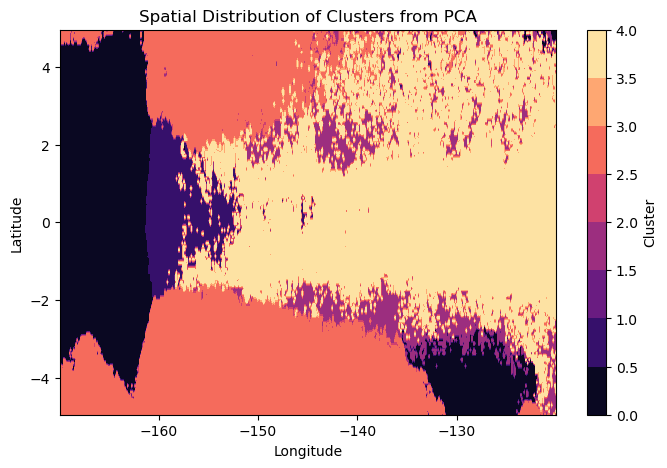

In [114]:
#plot spatial cluster map
plt.figure(figsize=(8, 5))
plt.contourf(clusters_map.columns, clusters_map.index, clusters_map.values, cmap="magma")
plt.colorbar(label="Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Clusters from PCA")

plt.show()


In [115]:
df_pca_scores.head()

lat         lon       time       PC1       PC2       PC3       PC4
0 -4.958333 -169.958344 2019-01-01  1.424373 -2.850817  0.692605  0.278886
1 -4.958333 -169.958344 2019-02-01 -0.822939  0.313056  0.677958  1.557121
2 -4.958333 -169.958344 2019-03-01 -0.355584 -4.005406  0.082494 -0.228703
3 -4.958333 -169.958344 2019-04-01 -2.149301 -4.432781 -1.225891 -0.249422
4 -4.958333 -169.958344 2019-05-01 -0.583353 -4.070968 -0.384475  0.421975

In [116]:
num_clusters = 4  
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
df_pca_scores["Cluster"] = kmeans.fit_predict(df_pca_scores[["PC1", "PC2", "PC3", "PC4"]])


In [117]:
cluster_means = df_pca_scores.groupby("Cluster")[["PC1", "PC2", "PC3", "PC4"]].mean()
cluster_means

PC1       PC2       PC3       PC4
Cluster                                        
0       -1.576604 -0.295750 -0.003769 -0.025552
1        0.736706  1.753348  0.044064 -0.070259
2        5.068537 -1.628395 -0.094936  0.115312
3        1.236912 -2.453727 -0.039237  0.226634

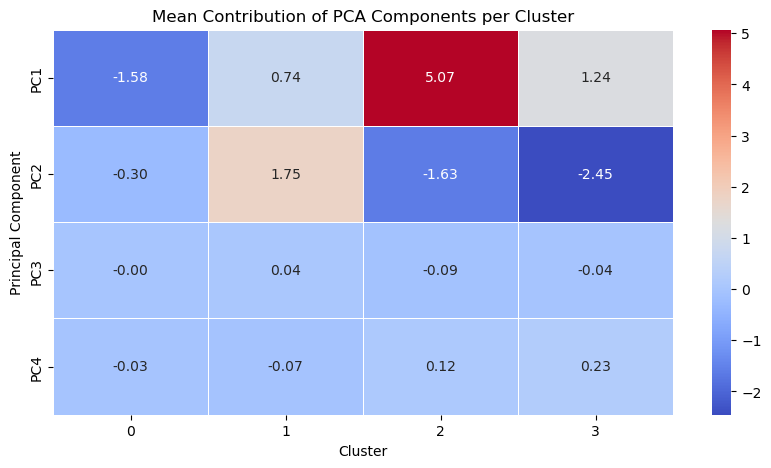

In [118]:
plt.figure(figsize=(10, 5))
sns.heatmap(cluster_means.T, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.xlabel("Cluster")
plt.ylabel("Principal Component")
plt.title("Mean Contribution of PCA Components per Cluster")
plt.show()

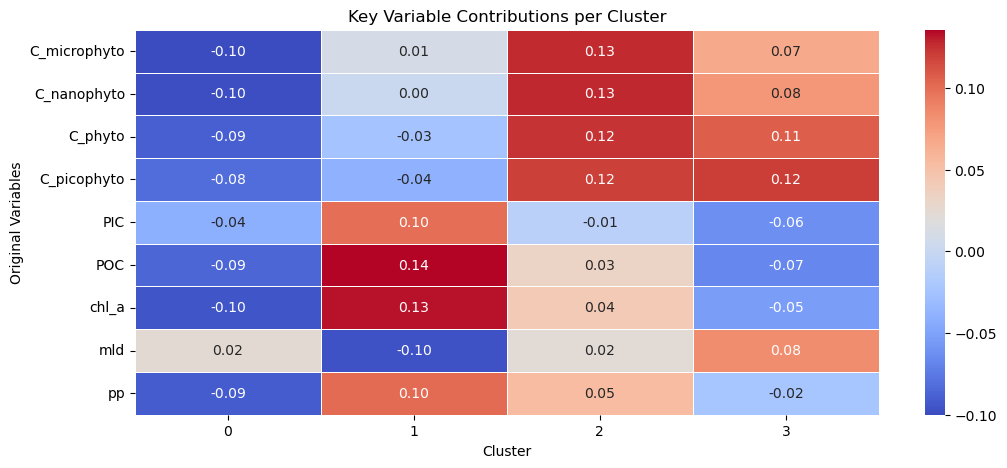

In [119]:
#  Merge Cluster Labels with Original Data
df_pca_scores_clustered = df_pca_scores.merge(df, on=["lat", "lon", "time"], how="left")

# Compute Mean Contribution of Each Original Variable per Cluster
cluster_variable_means = df_pca_scores_clustered.groupby("Cluster").mean().iloc[:, 3:]  # Skip lat, lon, time

#  Normalize for Better Interpretation
cluster_variable_means = cluster_variable_means.div(cluster_variable_means.abs().sum(axis=1), axis=0)

# Visualize the Contributions
plt.figure(figsize=(12, 5))
sns.heatmap(cluster_variable_means.iloc[:,4:].T, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.xlabel("Cluster")
plt.ylabel("Original Variables")
plt.title("Key Variable Contributions per Cluster")
plt.show()


- Clusters 0 & 1, dominated by phytoplankton biomass (C_microphyto, C_nanophyto, C_phyto, C_picophyto)
- Cluster 3, strong influence of POC, chl_a, pp, and PIC
- Cluster 2, negative contributions from most variables
- Mixed Layer Depth (mld), positively linked to Cluster 0 but negatively linked to Cluster 3.

In [120]:
# Find the dominant variable for each cluster
dominant_variable_per_cluster = cluster_variable_means.iloc[:,4:].idxmax(axis=1)
print("Most Important Variable per Cluster:")
print(dominant_variable_per_cluster)

Most Important Variable per Cluster:
Cluster
0            mld
1            POC
2    C_nanophyto
3    C_picophyto
dtype: object


In [121]:
# Map the dominant variable back to each pixel's cluster
df_pca_scores_clustered["Key Variable"] = df_pca_scores_clustered["Cluster"].map(dominant_variable_per_cluster)
# Aggregate spatial mean for each key variable
variable_map = df_pca_scores_clustered.groupby(["lat", "lon"])["Key Variable"].agg(lambda x: x.value_counts().idxmax()).reset_index()


In [122]:
variable_map

lat         lon Key Variable
0     -4.958333 -169.958344  C_picophyto
1     -4.958333 -169.875000  C_picophyto
2     -4.958333 -169.791656  C_picophyto
3     -4.958333 -169.708344  C_picophyto
4     -4.958333 -169.625000  C_picophyto
...         ...         ...          ...
71995  4.958333 -120.375000          mld
71996  4.958333 -120.291672          mld
71997  4.958333 -120.208328          mld
71998  4.958333 -120.125000          mld
71999  4.958333 -120.041672          mld

[72000 rows x 3 columns]

In [123]:

# Get unique key variables and assign numeric labels
unique_variables = variable_map["Key Variable"].unique()
variable_to_num = {var: i for i, var in enumerate(unique_variables)}

# Map categorical key variables to numeric values
variable_map["Key Variable Num"] = variable_map["Key Variable"].map(variable_to_num)

# Pivot for spatial representation
variable_grid = variable_map.pivot(index="lat", columns="lon", values="Key Variable Num")


In [124]:
variable_grid

lon        -169.958344  -169.875000  -169.791656  -169.708344  -169.625000  \
lat                                                                          
-4.958333            0            0            0            0            0   
-4.875000            0            0            0            0            0   
-4.791667            0            0            0            0            0   
-4.708333            0            0            0            0            0   
-4.625000            0            0            0            0            0   
...                ...          ...          ...          ...          ...   
 4.625000            0            0            0            0            0   
 4.708333            0            0            0            0            0   
 4.791667            0            0            0            0            0   
 4.875000            0            0            0            0            0   
 4.958333            0            0            0            0            0   

lon        -169.541656  -169.458344  -169.375000  -169.291656  -169.208344  \
lat                                                                          
-4.958333            0            0            0            0            0   
-4.875000            0            0            0            0            0   
-4.791667            0            0            0            0            0   
-4.708333            0            0            0            0            0   
-4.625000            0            0            0            0            0   
...                ...          ...          ...          ...          ...   
 4.625000            0            0            0            0            0   
 4.708333            0            0            0            0            0   
 4.791667            0            0            0            0            0   
 4.875000            0            0            0            0            0   
 4.958333            0            0            0            0            0   

lon        ...  -120.791672  -120.708328  -120.625000  -120.541672  \
lat        ...                                                       
-4.958333  ...            1            1            1            1   
-4.875000  ...            1            1            1            1   
-4.791667  ...            1            1            1            1   
-4.708333  ...            1            1            1            1   
-4.625000  ...            1            1            1            1   
...        ...          ...          ...          ...          ...   
 4.625000  ...            1            1            1            1   
 4.708333  ...            1            1            1            1   
 4.791667  ...            1            1            1            1   
 4.875000  ...            1            1            1            1   
 4.958333  ...            1            1            1            1   

lon        -120.458328  -120.375000  -120.291672  -120.208328  -120.125000  \
lat                                                                          
-4.958333            1            1            1            1            1   
-4.875000            1            1            1            1            1   
-4.791667            1            1            1            1            1   
-4.708333            1            1            1            1            1   
-4.625000            1            1            1            1            1   
...                ...          ...          ...          ...          ...   
 4.625000            1            1            1            1            1   
 4.708333            1            1            1            1            1   
 4.791667            1            1            1            1            1   
 4.875000            1            1            1            1            1   
 4.958333            1            1            1            1            1   

lon        -120.041672  
lat                

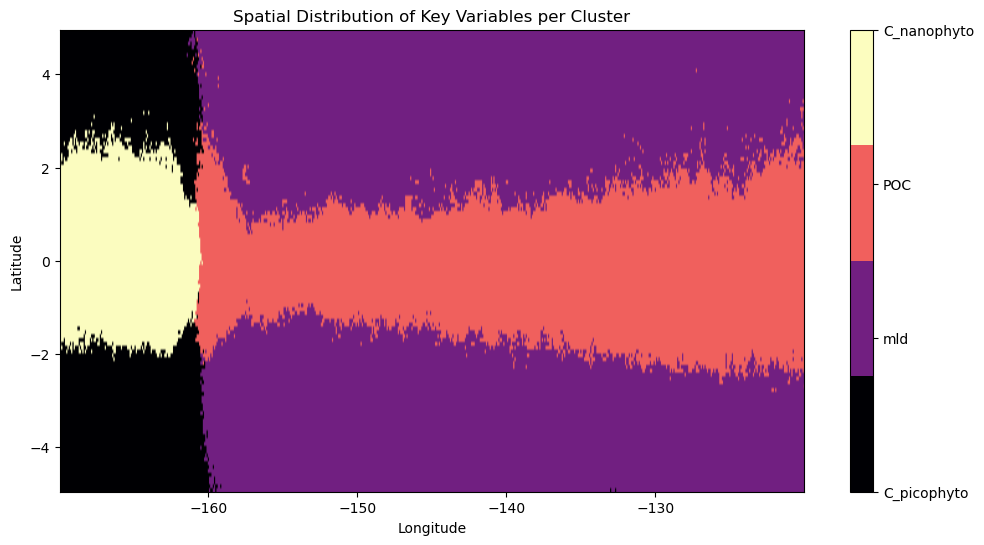

In [125]:
plt.figure(figsize=(12, 6))

# Define the categorical colormap
cmap = plt.get_cmap("magma", len(unique_variables))

# Plot the variable grid
plt.imshow(variable_grid, cmap=cmap, origin="lower", aspect="auto",  
           extent=[variable_grid.columns.min(), variable_grid.columns.max(),   
                   variable_grid.index.min(), variable_grid.index.max()])

# Create a colorbar with correct labels
cbar = plt.colorbar(ticks=range(len(unique_variables)))
cbar.set_ticklabels(unique_variables)

# Ensure correct axis labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Key Variables per Cluster")

plt.show()

**Insights from the Spatial Distribution of Key Variables per Cluster**

- The key variables driving each cluster exhibit well-defined spatial distributions, indicating distinct oceanographic or ecological regions.
- The westernmost part (black region) is dominated by C_nanophyto (yellow), suggesting a prevalence of nanophytoplankton in that area.
- The central region (red) is characterized by POC (Particulate Organic Carbon)
- The purple zone is linked to mld (Mixed layer depth)
- The black regions correspond to C_picophyto, indicating that picophytoplankton (smallest phytoplankton) dominate these zones.